In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

In [3]:
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.extraction.rois as roiutils

In [4]:
%matplotlib notebook

In [5]:
# import allensdk as ak
import analyze2p.correlations as cr


# Plotting

In [6]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

bw_colors = dict((v, [0.7]*3) for v in visual_areas)


# Source

In [102]:
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

response_type='dff'
experiment = 'rfs'
responsive_test='nstds'
if responsive_test=='nstds' and experiment=='rfs':
    responsive_thr=7.0
else:
    responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=1000
n_resamples=20
print(responsive_test, responsive_thr)

#### Responsive params
if experiment=='gratings':
    resp_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters, 
                            n_resamples=n_resamples)
else:
    resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)

data_id = '|'.join([traceid, resp_desc])
print(data_id)

nstds 7.0
traces001|dff_responsive-nstds-thr7.00


# Output dir

In [103]:
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       '%s_%s_%s' % (experiment, response_type, responsive_test))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds


# Load metadata

In [104]:
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin([experiment])].copy()
# all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                        if (va, dk) in meta[['visual_area', 'datakey']].values])
print(CELLS[['visual_area', 'datakey']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())
print(CELLS[['visual_area', 'datakey', 'cell']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())


/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
|    |   visual_area |
|:---|--------------:|
| Li |            27 |
| Lm |            25 |
| V1 |            19 |
|    |   visual_area |
|:---|--------------:|
| Lm |          4730 |
| V1 |          4007 |
| Li |          3754 |


# Load trial metrics

In [277]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [278]:
trial_epoch='plushalf' #'stimulus'
# NDATA0 = aggr.get_aggregate_data(experiment, traceid=traceid, 
#                       response_type=response_type, epoch=trial_epoch,
#                       responsive_test=responsive_test, verbose=False,
#                       responsive_thr=responsive_thr, n_stds=n_stds)
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_plushalf.pkl
... not in exp: 20190522_JC089_fov1
... not in exp: 20190527_JC092_fov3
... not in exp: 20190528_JC092_fov1
... not in exp: 20190602_JC091_fov1
... not in exp: 20190606_JC091_fov1
... not in exp: 20190607_JC091_fov1
... not in exp: 20190609_JC099_fov1
... not in exp: 20190612_JC099_fov1
... not in exp: 20190614_JC091_fov1
... not in exp: 20190617_JC099_fov1
... not in exp: 20191012_JC113_fov1
... not in exp: 20191012_JC113_fov2
... not in exp: 20191017_JC113_fov1
... not in exp: 20191018_JC113_fov1
... not in exp: 20191105_JC117_fov1
... not in exp: 20191106_JC120_fov1
... not in exp: 20191111_JC120_fov1
... not in exp: 20190602_JC080_fov2
... not in exp: 20191105_JC117_fov1
... not in exp: 20191111_JC117_fov1
... not in exp: 20191111_JC117

In [292]:
for (va, dk, cell), g in NDATA0.groupby(['visual_area', 'datakey', 'cell']):
    if len(g['experiment'].unique())>1:
        break

In [295]:
g['cell'].unique()

array([11], dtype=object)

In [108]:
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())


|    |   visual_area |
|:---|--------------:|
| V1 |          1728 |
| Lm |          1659 |
| Li |           798 |


# Load fits

In [296]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [297]:
%matplotlib notebook

In [298]:
fit_thr=0.5
if experiment == 'gratings':
    gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, 
                                fit_desc=resp_desc, return_missing=True) 
    gdata = hutils.split_datakey(gdata)
    # Get best GoF for each 
    best_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                    .transform(max) == gdata['gof']
    assert gdata.loc[best_ixs].groupby(['visual_area', 'datakey', 'cell'])\
            .count().max().max()==1
    bestg = gdata.loc[best_ixs].copy()
    bestg = hutils.split_datakey(bestg)
    print(bestg[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
    counts = bestg[bestg['gof']>=fit_thr][['visual_area', 'datakey', 'cell']]\
                        .drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
    print("Missing GRATINGS fits for %i datasets" % len(missing_))
elif experiment == 'rfs':
    # load fits, too
    do_spherical_correction=False
    rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                     do_spherical_correction=do_spherical_correction)
    rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
                                     reliable_only=False)
    # Combined rfs5/rfs10
    combined_rfs = rfutils.combine_rfs_single(rfdata) 
    #rfutils.average_rfs_select(rfdata)
    bestg = combined_rfs[combined_rfs['r2']>fit_thr].copy()
    counts = combined_rfs[['visual_area', 'datakey', 'cell']]\
                        .drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
else:
    bestg = aggr.get_strongest_response(NDATA0)
    counts = CELLS.groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
    counts = hutils.split_datakey(counts)

# Drop repeat FOVs based on N fits
u_dkeys = aggr.drop_repeats(counts)

N dpaths: 62, N unfit: 0
N datasets included: 62, N sessions excluded: 4
[V1] Animalid does not exist: JC078 


#### Filter fits

In [303]:
# Drop repeat FOVs based on N fits
if experiment=='rfs':
    # RFs may have 2 experiments (duplicate)
    unique_combined = pd.concat([g for (va, dk), g \
                                in combined_rfs.groupby(['visual_area', 'datakey'])
                                if (va, dk) in u_dkeys])
    assert 'experiment' in NDATA0.columns
    NDATA = pd.concat([g for (va, dk, exp), g in \
                NDATA0.groupby(['visual_area', 'datakey', 'experiment'])\
                if (va, dk, exp) in \
                unique_combined[['visual_area', 'datakey', 'experiment']].values])
else:
    NDATA = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])

print("All the data (N cells):")
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
print("UNIQUE datasets (N cells):")
print(NDATA[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())


All the data (N cells):
|    |   visual_area |
|:---|--------------:|
| V1 |          1728 |
| Lm |          1659 |
| Li |           798 |
UNIQUE datasets (N cells):
|    |   visual_area |
|:---|--------------:|
| V1 |          1728 |
| Lm |          1659 |
| Li |           798 |


In [304]:
%matplotlib notebook

In [309]:
gdata_u = pd.concat([g for (va, dk), g in bestg.groupby(['visual_area', 'datakey'])
                if (va, dk) in u_dkeys])
print(gdata_u['visual_area'].value_counts().to_markdown())

if experiment in ['gratings', 'rfs']:
    fit_thr=0.5
    thr_param = 'r2' if experiment=='rfs' else 'gof'
    final_dkeys = [u[1] for u in u_dkeys]
    final_fits = bestg[(bestg[thr_param]>=fit_thr) 
                     & (bestg.datakey.isin(final_dkeys))].copy()
    print(final_fits['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |           619 |
| Li |           296 |
| Lm |           280 |
|    |   visual_area |
|:---|--------------:|
| V1 |           622 |
| Li |           296 |
| Lm |           280 |


In [310]:
bestg['experiment'].unique()

array(['rfs10', 'rfs'], dtype=object)

# Example FOV & CELL

In [311]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [320]:
va = 'V1'
dk='20190617_JC097_fov1'
selective_only=False

ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# Select cells
if selective_only:
    curr_cells = gdata_u[(gdata_u.visual_area==va) 
                    & (gdata_u.datakey==dk)]['cell'].unique()
    if len(curr_cells)<5:
        print("Skipping.")
        #continue
else:
    curr_cells = ndf['cell'].unique()
    
# Select stimuli and trials
sdf = aggr.get_stimuli(dk, experiment=experiment)
curr_cfgs = sdf.index.tolist()
corrs, zscored = cr.calculate_corrs(ndf, return_zscored=True,
                                 curr_cells=curr_cells, curr_cfgs=curr_cfgs)


In [321]:
sdf.head()

,direction,luminance,stimtype,xpos,ypos,aspect,ori,position,speed,sf,size
config001,0,None,gratings,-50.0,-25.0,1,0,"(-50, -25)",10,0.25,5.0
config002,0,None,gratings,-50.0,-20.0,1,0,"(-50, -20)",10,0.25,5.0
config003,0,None,gratings,-50.0,-15.0,1,0,"(-50, -15)",10,0.25,5.0
config004,0,None,gratings,-50.0,-10.0,1,0,"(-50, -10)",10,0.25,5.0
config005,0,None,gratings,-50.0,-5.0,1,0,"(-50, -5)",10,0.25,5.0


In [322]:
# Get mean response per condition (columns=cells, rows=conditions)
if experiment=='gratings':
    params=['ori', 'sf', 'size', 'speed']
elif experiment=='blobs':
    params=['morphlevel', 'size'] #, 'yrot', 'xpos', 'ypos']
elif experiment=='rfs':
    params = ['position']
tuning_ = cr.trial_averaged_responses(zscored, sdf, params=params)
rois_ = [i for i in tuning_.columns if hutils.isnumber(i)]

#### Representational Similarity Matrix

In [323]:
if experiment == 'gratings':
    sdf['tf'] = sdf['sf']*sdf['speed']
    xlabels = ['%i|%.2f|%i|%i' % (o, sf, sz, sp) for (o, sf, sz, sp) in \
               sdf.loc[tuning_['config']][['ori', 'sf', 'size', 'speed']].values]
elif experiment=='blobs':
    xlabels = ['%i|%.i' % (mp, sz) for (mp, sz) in\
               sdf.loc[tuning_['config']][params].values]
elif experiment == 'rfs':
    xlabels = ['%s' % str(p[0]) for p in\
               sdf.loc[tuning_['config']][params].values]
    
mat_ = tuning_[rois_].T.corr(method='spearman')
msk_ = np.triu(np.ones_like(mat_, dtype=bool))

In [324]:
xlabels[0:10]

['(-50, -25)',
 '(-50, -20)',
 '(-50, -15)',
 '(-50, -10)',
 '(-50, -5)',
 '(-50, 0)',
 '(-50, 5)',
 '(-50, 10)',
 '(-50, 15)',
 '(-50, 20)']

<IPython.core.display.Javascript object>


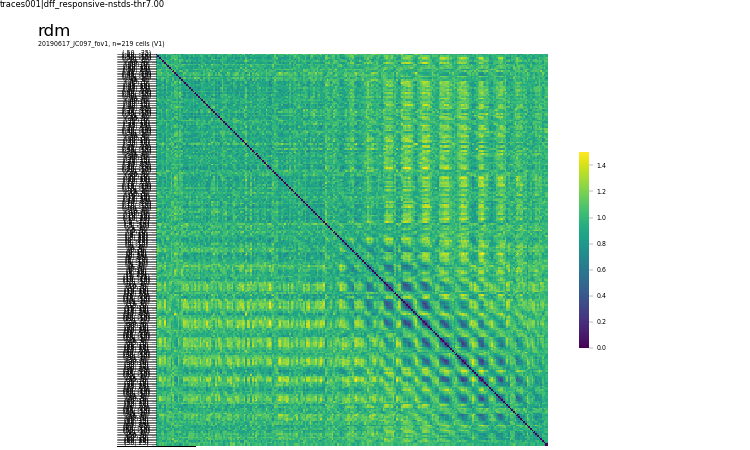

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds rdm__EXAMPLE_20190617_JC097_fov1


In [325]:
plot_rdm = True

if plot_rdm:
    pmat = 1-mat_
    cmap='viridis' # 0=totally same, 2+ more dissimilar
    plot_name = 'rdm'
else:
    pmat = mat_.copy()
    cmap = 'RdBu_r' # red, corr=1, blue, anticorr=-1
    plot_name = 'corr'
    
fig, ax = pl.subplots(1,1,figsize=(10, 6))
sns.heatmap(pmat, cmap=cmap, ax=ax, #mask=msk_, 
            square=True, cbar_kws={"shrink": 0.5})

#ax.set_aspect('equal')
fig.text(0.05, 0.9, '%s, n=%i cells (%s)' % (dk, len(rois_), va))

#Below 3 lines remove default labels
labels = ['' for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.set_ylabel('')
ax.set_xticks([])

pplot.label_group_bar_table(ax, mat_, offset=0.1, lw=0.5)
fig.subplots_adjust(bottom=.01*mat_.index.nlevels, left=0.05, right=0.9)
fig.text(0.05, 0.92, plot_name, fontsize=16)

pplot.label_figure(fig, data_id)

figname = '%s__EXAMPLE_%s' % (plot_name, dk)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


## Correlations

<IPython.core.display.Javascript object>


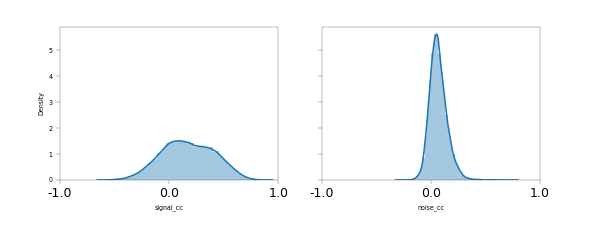

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [148]:
fig, axn = pl.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)
sns.distplot(corrs['signal_cc'], ax=axn[0])
sns.distplot(corrs['noise_cc'], ax=axn[1])
for ax in axn.flat:
    ax.set_xlim([-1, 1])
    ax.set_xticks(np.linspace(-1, 1, 3))
    ax.set_xticklabels(np.linspace(-1, 1, 3), fontsize=12)
pl.subplots_adjust(bottom=0.2, left=0.1)

## Signal corrs. vs. Cortical distance

#### Load spatial info

In [326]:
session, animalid, fovnum = hutils.split_datakey_str(dk)
fov = 'FOV%i_zoom2p0x' % fovnum

# Position info
rois_ = ndf['cell'].unique()
fcoords = roiutils.load_roi_coords(animalid, session, fov, traceid=traceid)
pos_ = fcoords['roi_positions'].loc[rois_].copy()

In [327]:
# Add cortical distances
cc_ = corrs.copy()
cc_ = cr.get_pw_cortical_distance(cc_, pos_)
cc_['visual_area'] = va
cc_['datakey'] = dk
cc_.head()

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,cortical_distance,visual_area,datakey
0,0,1,0.716846,0_1,0.767977,14.677900,V1,20190617_JC097_fov1
1,0,2,-0.129019,0_2,-0.073064,53.353902,V1,20190617_JC097_fov1
2,0,3,0.288285,0_3,0.247540,79.267714,V1,20190617_JC097_fov1
3,0,4,-0.026673,0_4,0.001899,24.855400,V1,20190617_JC097_fov1
4,0,5,0.035206,0_5,0.076215,40.316287,V1,20190617_JC097_fov1


In [328]:
importlib.reload(cr)
%matplotlib notebook

In [329]:
bin_labels

['1st', '2nd', '3rd', '4th']

| binned_cortical_distance   |   cortical_distance |   signal_cc |
|:---------------------------|--------------------:|------------:|
| 1st                        |             158.928 |    0.217425 |
| 2nd                        |             324.407 |    0.193368 |
| 3rd                        |             471.299 |    0.159337 |
| 4th                        |             704.059 |    0.117367 |


<IPython.core.display.Javascript object>


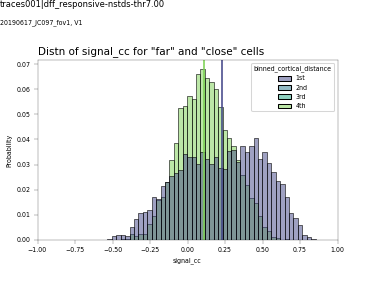

First and Last ~cortical_distance~ quartiles, diff <signal_cc> = nan
signal_cc_Q_cortical_distance__EXAMPLE_20190617_JC097_fov1


In [331]:
n_bins=4
use_quartile=True
custom_bins=False
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
# bin_colors = dict((k, v) for k, v in zip(np.arange(0, n_bins), bin_labels))

metric = 'signal_cc'
to_quartile='cortical_distance'
# Bin data
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(cc_, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
print(bcorrs.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]]\
      .mean().to_markdown())
# Plot
fig, ax = pl.subplots(figsize=(5,4))
plot_bins = [bin_labels[0], bin_labels[-1]]
ax = cr.plot_quartile_dists_FOV(bcorrs, metric=metric, to_quartile=to_quartile,
                              bin_labels=bin_labels, bin_colors=bin_colors, ax=ax)
pl.subplots_adjust(bottom=0.2)
ax.set_xlim([-1, 1])
# print some stuff
lo_median = cc_[cc_['binned_%s' % to_quartile]==0][metric].median()
hi_median = cc_[cc_['binned_%s' % to_quartile]==3][metric].median()
print('First and Last ~%s~ quartiles, diff <%s> = %.2f' \
          % (to_quartile, metric, hi_median - lo_median))
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
pplot.label_figure(fig, data_id)
fig.text(0.0, 0.92, '%s, %s' % (dk, va))
fig.axes[0].set_title('Distn of %s for "far" and "close" cells' % metric, \
                    loc='left', fontsize=10)
figname = '%s_Q_%s__EXAMPLE_%s' % (metric, to_quartile, dk)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

## Signal corr. vs RF overlap

In [332]:
%matplotlib notebook

In [333]:
# # Load RF data
# do_spherical_correction=False
# # Get cells and metadata
# assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
#                                                 experiments=['rfs', 'rfs10']) 
# # Load RF fit data
# rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
#                                  do_spherical_correction=do_spherical_correction)
# rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
#                                  reliable_only=False)
# # Combined rfs5/rfs10
# combined_rfs = rfutils.average_rfs_select(rfdata)

In [334]:
combined_rfs['experiment'].unique()

array(['rfs10', 'rfs'], dtype=object)

In [335]:
va, dk

('V1', '20190617_JC097_fov1')

In [336]:
# RF info
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
rfs_ = combined_rfs[(combined_rfs.visual_area==va) & (combined_rfs.datakey==dk)
                   & (combined_rfs['cell'].isin(rois_))].copy()
rfs_.index = rfs_['cell'].values

# Get rf overlaps
rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
overlaps_ = rfutils.get_rf_overlaps(rf_polys)
overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) for c1, c2 in overlaps_[['cell_1', 'cell_2']].values]

# merge RF and CC/distance data
has_both = np.intersect1d(overlaps_['neuron_pair'], cc_['neuron_pair'])
ccrf_ = pd.merge(overlaps_[overlaps_['neuron_pair'].isin(has_both)],
               cc_[cc_['neuron_pair'].isin(has_both)])

In [338]:
len(rois_), rfs_.shape

(219, (80, 28))

| binned_signal_cc   |   signal_cc |   area_overlap |
|:-------------------|------------:|---------------:|
| 1st                |    0.183779 |       0.261881 |
| 2nd                |    0.373932 |       0.393551 |
| 3rd                |    0.4995   |       0.523651 |
| 4th                |    0.632581 |       0.652089 |
First and Last ~signal_cc~ quartiles, diff <area_overlap> = 0.39
| binned_signal_cc   |   signal_cc |   area_overlap |
|:-------------------|------------:|---------------:|
| 1st                |    0.183779 |       0.261881 |
| 2nd                |    0.373932 |       0.393551 |
| 3rd                |    0.4995   |       0.523651 |
| 4th                |    0.632581 |       0.652089 |


<IPython.core.display.Javascript object>


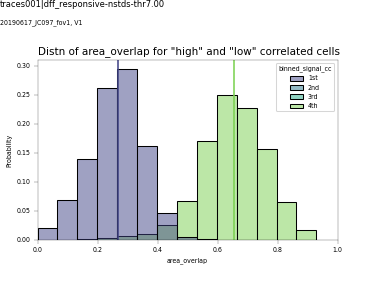

area_overlap_Q_signal_cc__EXAMPLE_20190617_JC097_fov1


In [339]:
# Bin into quartiles
metric = 'area_overlap'
to_quartile='signal_cc'
# Bin into quartiles
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(ccrf_, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)

print(bcorrs.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]]\
      .mean().to_markdown())
# print some stuff
lo_median = bcorrs[bcorrs['binned_%s' % to_quartile]==bin_labels[0]][metric].median()
hi_median = bcorrs[bcorrs['binned_%s' % to_quartile]==bin_labels[-1]][metric].median()
print('First and Last ~%s~ quartiles, diff <%s> = %.2f' \
          % (to_quartile, metric, hi_median - lo_median))

print(bcorrs.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]]\
      .mean().to_markdown())

# Plot metric X for top and bottom quartiles
fig, ax = pl.subplots(figsize=(5,4))
plot_bins = [bin_labels[0], bin_labels[-1]]
ax = cr.plot_quartile_dists_FOV(bcorrs, metric=metric, to_quartile=to_quartile,
                              bin_labels=bin_labels, bin_colors=bin_colors, ax=ax)
ax.set_xlim([0, 1])
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
fig.text(0.0, 0.92, '%s, %s' % (dk, va))
fig.axes[0].set_title('Distn of %s for "high" and "low" correlated cells'\
                    % metric, loc='left', fontsize=10)

pplot.label_figure(fig, data_id)
figname = '%s_Q_%s__EXAMPLE_%s' % (metric, to_quartile, dk)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

# Aggregate correlation metrics

In [340]:
#### Get cell position data
NDATA['experiment'] = experiment
posdf = NDATA[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)
# Get ROI positions
posdf = aggr.add_roi_positions(posdf)

Adding ROI position info...


In [341]:
ignore = ['20190320_JC067_fov1', '20190321_JC070_fov1', '20191111_JC120_fov1']
redo_pos = []
for (va, dk), g in posdf.groupby(['visual_area', 'datakey']):
    if len(g['ml_pos'].unique())==1:
        redo_pos.append(dk)
print(redo_pos)
for dk in redo_pos:
    if dk in ignore: 
        continue
    session, animalid, fovnum = hutils.split_datakey_str(dk)
    fovinfo = roiutils.load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                                      traceid=traceid, create_new=True)

[]


In [342]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [343]:
NDATA['experiment'].unique()

array(['rfs'], dtype=object)

In [ ]:
#ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# NDATA already contains only unique dkeys
CORRS=None
min_ncells=5
selective_only=False
c_list=[]
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    # Select cells
    if selective_only:
        rois_ = gdata_u[(gdata_u.visual_area==va) 
                        & (gdata_u.datakey==dk)]['cell'].unique()
    else:
        rois_ = ndf['cell'].unique()
    if len(rois_)<min_ncells:
        print("Skipping - (%s, %s)" % (va, dk))
        continue
    # Select stimuli and trials
    sdf = aggr.get_stimuli(dk, experiment=experiment)
    if sdf is None:
        continue
    curr_cfgs = sdf.index.tolist()
    cc_, zscored = cr.calculate_corrs(ndf, return_zscored=True,
                                     curr_cells=rois_, curr_cfgs=curr_cfgs)
    # Get position info
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    cc_ = cr.get_pw_cortical_distance(cc_, pos_)
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    c_list.append(cc_)
CORRS = pd.concat(c_list)
CORRS.head()

(20190527_JC092_fov3) No labels.npz for exp name ~rfs~. Found:
(20190528_JC092_fov1) No labels.npz for exp name ~rfs~. Found:
(20190606_JC091_fov1) No labels.npz for exp name ~rfs~. Found:
(20190607_JC091_fov1) No labels.npz for exp name ~rfs~. Found:
(20190609_JC099_fov1) No labels.npz for exp name ~rfs~. Found:
(20190612_JC099_fov1) No labels.npz for exp name ~rfs~. Found:
(20190614_JC091_fov1) No labels.npz for exp name ~rfs~. Found:
(20190617_JC099_fov1) No labels.npz for exp name ~rfs~. Found:
(20191012_JC113_fov1) No labels.npz for exp name ~rfs~. Found:
(20191012_JC113_fov2) No labels.npz for exp name ~rfs~. Found:
(20191018_JC113_fov1) No labels.npz for exp name ~rfs~. Found:
(20191105_JC117_fov1) No labels.npz for exp name ~rfs~. Found:
(20191106_JC120_fov1) No labels.npz for exp name ~rfs~. Found:
(20191111_JC120_fov1) No labels.npz for exp name ~rfs~. Found:


In [ ]:
print(CORRS[['visual_area', 'datakey']].drop_duplicates()['visual_area']\
      .value_counts().to_markdown())


In [262]:
CORRS.head()

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,cortical_distance,visual_area,datakey
0,128,136,-0.099994,128_136,0.070239,208.781022,Li,20190522_JC089_fov1
1,128,137,0.552000,128_137,0.314681,114.552472,Li,20190522_JC089_fov1
2,128,146,0.551743,128_146,0.172816,55.799917,Li,20190522_JC089_fov1
3,128,106,-0.140536,128_106,0.051247,331.863463,Li,20190522_JC089_fov1
4,128,108,0.346904,128_108,0.178364,447.984229,Li,20190522_JC089_fov1


In [263]:
%matplotlib notebook

<IPython.core.display.Javascript object>


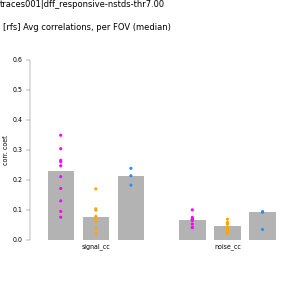

In [264]:
meancorrs = CORRS.groupby(['visual_area', 'datakey'])[['signal_cc', 'noise_cc']]\
                .mean() #.reset_index()
df_s = meancorrs.stack()\
    .rename_axis(index={'id': 'id', 'date': 'date', None: 'corr_type'})\
    .rename('corr_value').reset_index()

g = sns.FacetGrid(df_s, height=4)
g.map_dataframe(sns.stripplot, x="corr_type", y="corr_value", 
                hue="visual_area", palette=area_colors, 
                hue_order=visual_areas, dodge=True, size=3, jitter=False)
g.map_dataframe(sns.barplot, x="corr_type", y="corr_value", 
                hue="visual_area", palette=bw_colors, 
                estimator=np.median, #ci='sd',
                hue_order=visual_areas, dodge=True, errwidth=0)
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
pplot.change_width(g.fig.axes[0], 0.2)
sns.despine(bottom=True)
pl.ylim([0, 0.6])
g.fig.axes[0].tick_params(which='both', axis='x', size=0)
pl.ylabel('corr. coef.')
pplot.label_figure(g.fig, data_id)
g.fig.text(0.01, 0.9,'[%s] Avg correlations, per FOV (median)' \
           % experiment, fontsize=8)

plot_type = 'selectiveonly' if selective_only else 'allcells'
figname = 'correlations_byfov_%s' % plot_type
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

## Signal corrs for near vs. far cells

In [25]:
n_bins=4
custom_bins=False
cmap='viridis'
# ------------------------------

<IPython.core.display.Javascript object>


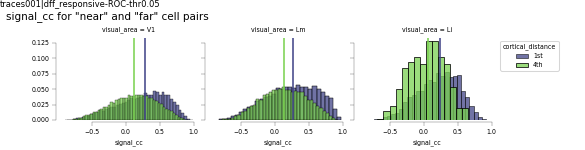

signal_cc_Q_cortical_distance_aggr


In [27]:
metric = 'signal_cc'
to_quartile='cortical_distance'
custom_bins=False
use_quartile=True
# Bin data
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(CORRS, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()
# Plot metric X for top and bottom quartiles
g = cr.plot_quartile_dists_by_area(bcorrs, bin_labels, bin_colors,
                        metric=metric,
                        to_quartile=to_quartile)
sns.despine(trim=True, offset=2)
g.fig.text(0.01, 0.87, '%s for "near" and "far" cell pairs' % metric, fontsize=10)
# Save
pplot.label_figure(g.fig, data_id)
figname = '%s_Q_%s_aggr' % (metric, to_quartile)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

#### by fov

In [28]:
%matplotlib notebook

<IPython.core.display.Javascript object>


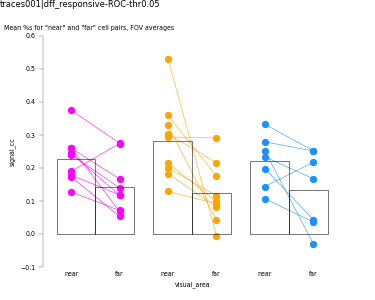

|    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |        3 |   0.02  | V1            |
|  1 |        0 |   0.004 | Lm            |
|  2 |        4 |   0.109 | Li            |
signal_cc_Q_cortical_distance_byFOV


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [38]:
fovmeans = bcorrs\
                .groupby(['binned_%s' % to_quartile, 'visual_area', 'datakey'])\
                .mean().reset_index().dropna()
means_ = pd.concat([fc for (va, dk), fc in fovmeans\
            .groupby(['visual_area', 'datakey'])if len(fc)==len(bin_labels)])

plot_bins = [bin_labels[0], bin_labels[-1]]
currd = means_[means_['binned_%s' % to_quartile].isin(plot_bins)].copy()

fig, ax = pl.subplots()
metric='signal_cc'
ax, pstats = pplot.pairwise_compare_single_metric(currd, 
                  curr_metric=metric, ax=ax, bar_ci=None,
                  c1=plot_bins[0], c2=plot_bins[-1], 
                  c1_label='near', c2_label='far',
                  compare_var='binned_%s' % to_quartile,
                  return_stats=True, ttest=False)
ax.set_ylim([-0.1, 0.6])
fig.text(0.01, 0.9, 'Mean %s for "near" and "far" cell pairs, FOV averages')
print(pstats.to_markdown())

pplot.label_figure(fig, data_id)
figname = '%s_Q_%s_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

|    |   visual_area |
|:---|--------------:|
| V1 |             9 |
| Lm |             9 |
| Li |             7 |


<IPython.core.display.Javascript object>


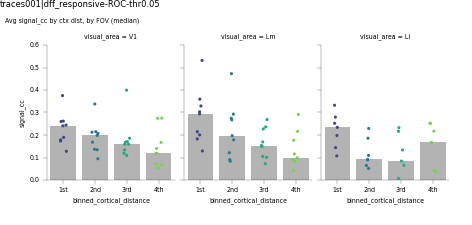

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


signal_cc_Q_cortical_distance_allbins_byFOV


In [39]:
dist_cmap = 'viridis'
print(means_[['visual_area', 'datakey']].drop_duplicates()['visual_area']\
        .value_counts().to_markdown())
g = cr.plot_y_by_binned_x(means_, bin_labels, connect_fovs=False,cmap=dist_cmap,
                       metric=metric, to_quartile=to_quartile)
pl.ylim([0, 0.6])

g.fig.text(0.01, 0.9, 'Avg %s by ctx dist, by FOV (median)' % metric)
pplot.label_figure(g.fig, data_id)

figname = '%s_Q_%s_allbins_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

In [41]:
import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for va, df_ in means_.groupby('visual_area'):
    samples = [b_df for b, b_df in df_.groupby('binned_%s' % to_quartile)[metric]]
    f_val, p_val = ss.f_oneway(*samples)
    print('Name: {}, F value: {:.3f}, p value: {:.3f}'.format(va, f_val, p_val))

for va, df_ in means_.groupby('visual_area'):
    print('Name {}'.format(va), 
          pairwise_tukeyhsd(df_[metric], df_['binned_%s' % to_quartile]))

Name: Li, F value: 2.374, p value: 0.095
Name: Lm, F value: 4.048, p value: 0.015
Name: V1, F value: 1.801, p value: 0.167
Name Li Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1st    2nd  -0.1035 0.1761 -0.2384 0.0313  False
   1st    3rd  -0.1192 0.0965 -0.2541 0.0156  False
   1st    4th  -0.0867 0.3099 -0.2216 0.0481  False
   2nd    3rd  -0.0157    0.9 -0.1506 0.1192  False
   2nd    4th   0.0168    0.9 -0.1181 0.1517  False
   3rd    4th   0.0325    0.9 -0.1024 0.1674  False
---------------------------------------------------
Name Lm Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1st    2nd   -0.063 0.5645 -0.1946  0.0686  False
   1st    3rd  -0.1181 0.0912 -0.2498  0.0135  False
   1st    4th  -0.1593 0.0128 -0.2909 -0.0277   True
   2nd    3rd  -0.0551 

# RF "similarity"

In [42]:
# Load RF data
do_spherical_correction=False
# Get cells and metadata
assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
                                                experiments=['rfs', 'rfs10']) 
# Load RF fit data
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                 do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
                                 reliable_only=False)
# Combined rfs5/rfs10
combined_rfs = rfutils.average_rfs_select(rfdata)

N dpaths: 62, N unfit: 0
N datasets included: 62, N sessions excluded: 4


In [43]:
# Get ROI positions
rfdf = aggr.add_roi_positions(combined_rfs)
rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
rfCELLS = pd.concat([g for (va, dk), g in \
                     assigned_cells.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in rf_dkeys])

Adding ROI position info...


#### Combine GDATA and RFDATA

In [46]:
strong_g = aggr.get_strongest_response(NDATA0)

In [47]:
RFS=[]
GFS=[]
for (va, dk), gr_ in strong_g.groupby(['visual_area', 'datakey']):
    rfs_ = rfdf[(rfdf['visual_area']==va) 
                      & (rfdf['datakey']==dk)].copy()
    if len(rfs_)==0:
        continue
    rf_cells = rfs_['cell'].unique()
    gr_cells = gr_['cell'].unique()
    common_cells = np.intersect1d(rf_cells, gr_cells)
    #print('%s: %i cells in common (%s)' % (va, len(common_cells), dk))
    RFS.append(rfs_[rfs_['cell'].isin(common_cells)])
    GFS.append(gr_[gr_['cell'].isin(common_cells)])
    
RFS = pd.concat(RFS, axis=0).reset_index(drop=True)
GFS = pd.concat(GFS, axis=0).reset_index(drop=True)
print(GFS.shape, RFS.shape)
cols_to_use = RFS.columns.difference(GFS.columns)
DF0 = pd.merge(GFS, RFS[cols_to_use], left_index=True, right_index=True, how='outer')
if experiment=='gratings':
    DF0['theta_deg'] = np.rad2deg(DF0['theta_Mm_c'])
    # Assign "preferred theta" for tested values
    theta_vals = np.linspace(0, 360, 9)
print(DF0.dropna()['visual_area'].value_counts().to_markdown())

(890, 6) (890, 34)
|    |   visual_area |
|:---|--------------:|
| V1 |           467 |
| Lm |           264 |
| Li |           159 |


In [48]:
DF0.tail()

,visual_area,datakey,cell,config,trial,response,animalid,aniso_index,anisotropy,ap_pos,...,session,std_avg,std_x,std_y,theta,theta_Mm_c,theta_Mm_deg,theta_c,x0,y0
885,V1,20191006_JC110_fov1,301,config002,840.151515,0.037069,JC110,-0.127230,0.194888,624.519765,...,20191006,10.921589,13.050073,8.793105,6.108721,-0.174464,350.003958,-0.174464,32.758629,3.102941
886,V1,20191006_JC110_fov1,302,config031,845.848485,0.084137,JC110,-0.033032,0.204184,357.197652,...,20191006,6.638975,7.994547,5.283403,5.850719,-0.432466,335.221508,-0.432466,30.398411,-2.053308
887,V1,20191006_JC110_fov1,307,config047,835.970588,0.064378,JC110,-0.037096,0.246521,338.761644,...,20191006,12.261988,15.284825,9.239150,0.438698,0.438698,25.135549,0.438698,34.280207,-1.863295
888,V1,20191006_JC110_fov1,310,config001,833.147059,0.053763,JC110,-0.082874,0.125788,368.720157,...,20191006,9.473029,10.664619,8.281439,0.171417,0.171417,9.821492,0.171417,32.187542,-4.836219
889,V1,20191006_JC110_fov1,336,config001,833.147059,0.036240,JC110,-0.225882,0.235024,345.675147,...,20191006,8.669491,6.631956,10.707025,1.551346,-0.019450,178.885573,1.551346,37.105320,-2.453987


In [49]:
counts = DF0.groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
counts = hutils.split_datakey(counts)

# Drop repeat FOVs based on N fits
u_dkeys = aggr.drop_repeats(counts)

DF = pd.concat([g for (va, dk), g in DF0.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in u_dkeys])
print(DF.dropna()['visual_area'].value_counts().to_markdown())


[V1] Animalid does not exist: JC078 
|    |   visual_area |
|:---|--------------:|
| V1 |           392 |
| Lm |           182 |
| Li |           117 |


In [51]:
%matplotlib inline

In [52]:
ndata_ccrf = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])
                       if (va, dk) in 
                        DF[['visual_area', 'datakey']].drop_duplicates().values.astype(tuple)
                       ])

In [53]:
print(ndata_ccrf[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())


|    |   visual_area |
|:---|--------------:|
| Li |            18 |
| Lm |            17 |
| V1 |            16 |


In [54]:
#ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# NDATA already contains only unique dkeys
min_ncells=5
selective_only=False
c_list=[]
for (va, dk), ndf in ndata_ccrf.groupby(['visual_area', 'datakey']):
    # Select cells
    if selective_only:
        rois_ = gdata_u[(gdata_u.visual_area==va) 
                        & (gdata_u.datakey==dk)]['cell'].unique()
    else:
        rois_ = ndf['cell'].unique()
    if len(rois_)<min_ncells:
        print("Skipping - (%s, %s)" % (va, dk))
        continue
    # Select stimuli and trials
    sdf = aggr.get_stimuli(dk, experiment=experiment)
    curr_cfgs = sdf.index.tolist()
    cc_, zscored = cr.calculate_corrs(ndf, return_zscored=True,
                                     curr_cells=rois_, curr_cfgs=curr_cfgs)
    # Get position info
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    if len(pos_)==0:
        print("No position info: %s" % dk)
        continue
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    cc_ = cr.get_pw_cortical_distance(cc_, pos_)
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    c_list.append(cc_)
CORRS = pd.concat(c_list)
CORRS.head()

No position info: 20190314_JC070_fov1
Skipping - (Li, 20190319_JC067_fov1)
Skipping - (Li, 20190320_JC067_fov1)
Skipping - (Li, 20190321_JC070_fov1)
No position info: 20190327_JC073_fov1
No position info: 20190602_JC091_fov1
No position info: 20190606_JC091_fov1
No position info: 20190612_JC099_fov1
No position info: 20191018_JC113_fov1
No position info: 20191111_JC120_fov1
No position info: 20190327_JC073_fov1
No position info: 20190504_JC078_fov1
No position info: 20190508_JC083_fov1
No position info: 20190513_JC078_fov1
No position info: 20190517_JC083_fov1
No position info: 20190603_JC080_fov1
Skipping - (Lm, 20191111_JC120_fov1)
No position info: 20190420_JC076_fov1
No position info: 20190504_JC078_fov1
No position info: 20190507_JC083_fov1
No position info: 20190508_JC083_fov1
No position info: 20190509_JC078_fov1
No position info: 20190511_JC083_fov1
No position info: 20190517_JC083_fov1


,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,cortical_distance,visual_area,datakey
0,113,138,-0.133458,113_138,0.121274,263.711661,Li,20190315_JC070_fov1
1,113,145,-0.144237,113_145,0.153354,311.392906,Li,20190315_JC070_fov1
2,113,147,0.148011,113_147,0.169984,138.113869,Li,20190315_JC070_fov1
3,113,150,0.222888,113_150,-0.000957,183.554930,Li,20190315_JC070_fov1
4,113,152,0.527065,113_152,0.111703,156.653814,Li,20190315_JC070_fov1


In [55]:
print(min_ncells)

5


In [56]:
# RF info
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
r_list=[]
for (va, dk), cc_ in CORRS.groupby(['visual_area', 'datakey']):
    rfs_ = rfdf[(rfdf.visual_area==va) 
                      & (rfdf.datakey==dk)].copy()
    if len(rfs_)<min_ncells:
        print("- skipping: %s, %s" % (va, dk))
        continue
    rfs_.index = rfs_['cell'].values
    # Get rf overlaps
    rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
    overlaps_ = rfutils.get_rf_overlaps(rf_polys)
    overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
    overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) \
                                for c1, c2 in overlaps_[['cell_1', 'cell_2']].values]
    # merge RF and CC/distance data
    has_both = np.intersect1d(overlaps_['neuron_pair'], cc_['neuron_pair'])
    ccrf_ = pd.merge(overlaps_[overlaps_['neuron_pair'].isin(has_both)],
                   cc_[cc_['neuron_pair'].isin(has_both)])
    # add RF position distances
    # Coords of cell1 in pair, in order
    coords1 = np.array(rfs_.loc[ccrf_['cell_1'].values][['x0', 'y0']])
    # Coords of cell2 in pair 
    coords2 = np.array(rfs_.loc[ccrf_['cell_2'].values][['x0', 'y0']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    ccrf_['rf_distance'] = dists
    # Add diff in RF orientation
    v1 = np.array(rfs_.loc[ccrf_['cell_1'].values]['theta_Mm_deg'].values)
    v2 = np.array(rfs_.loc[ccrf_['cell_2'].values]['theta_Mm_deg'].values)
    diffs = (v1-v2) % 90.
    ccrf_['rf_orientation'] = diffs
    r_list.append(ccrf_)
    
CCRF = pd.concat(r_list, axis=0)

- skipping: Li, 20190315_JC070_fov1
- skipping: Li, 20190316_JC070_fov1
- skipping: Li, 20190322_JC073_fov1
- skipping: Li, 20190422_JC076_fov1
- skipping: Lm, 20190306_JC061_fov3
- skipping: Lm, 20190322_JC073_fov1
- skipping: Lm, 20190422_JC076_fov1


In [57]:
print(CCRF[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |             9 |
| Lm |             7 |
| Li |             3 |


In [58]:
metric = 'signal_cc'
to_quartile='area_overlap'
n_bins=4
# Bin data
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(CCRF, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
print(bcorrs.groupby(['visual_area', 'binned_%s' \
                      % to_quartile])[[to_quartile, metric]].mean().to_markdown())

|               |   area_overlap |   signal_cc |
|:--------------|---------------:|------------:|
| ('Li', '1st') |       0.237751 |   0.109803  |
| ('Li', '2nd') |       0.428206 |   0.242467  |
| ('Li', '3rd') |       0.549784 |   0.327808  |
| ('Li', '4th') |       0.688369 |   0.296209  |
| ('Lm', '1st') |       0.218866 |   0.0683592 |
| ('Lm', '2nd') |       0.428955 |   0.240019  |
| ('Lm', '3rd') |       0.554075 |   0.288493  |
| ('Lm', '4th') |       0.697577 |   0.348023  |
| ('V1', '1st') |       0.273769 |   0.139905  |
| ('V1', '2nd') |       0.43341  |   0.237153  |
| ('V1', '3rd') |       0.55301  |   0.318383  |
| ('V1', '4th') |       0.704633 |   0.410408  |


In [59]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

signal_ccQ_area_overlap_aggr


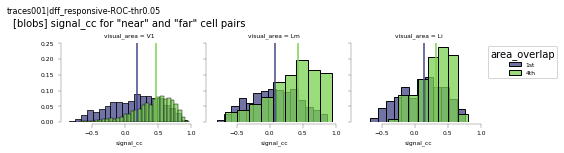

In [60]:
g = cr.plot_quartile_dists_by_area(bcorrs, bin_labels, bin_colors,
                        metric=metric, to_quartile=to_quartile, extrema_only=True)

g.fig.text(0.01, 0.87, '[%s] %s for "near" and "far" cell pairs' \
           % (experiment, metric), fontsize=10)
pplot.label_figure(g.fig, data_id)
# Save
figname = '%sQ_%s_aggr' % (metric, to_quartile)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


|    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |        0 |   0.016 | V1            |
|  1 |        1 |   0.062 | Lm            |
|  2 |        0 |   0.25  | Li            |
signal_cc_Q_area_overlap_byFOV /n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC


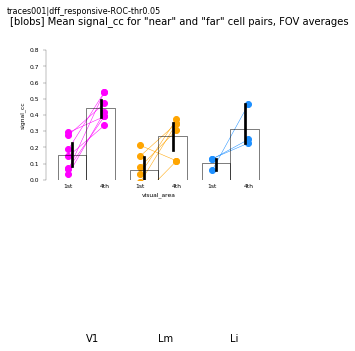

In [61]:
fovmeans = bcorrs\
                .groupby(['binned_%s' % to_quartile, 'visual_area', 'datakey'])\
                .mean().reset_index().dropna()
means_ = pd.concat([fc for (va, dk), fc in fovmeans\
            .groupby(['visual_area', 'datakey'])if len(fc)==len(bin_labels)])

currd = means_[means_['binned_%s' % to_quartile].isin(plot_bins)].copy()
fig, ax = pl.subplots(figsize=(4,3))
ax, pstats = pplot.pairwise_compare_single_metric(currd, 
                  curr_metric=metric, ax=ax,
                  c1=plot_bins[0], c2=plot_bins[-1], 
                  compare_var='binned_%s' % to_quartile,
                  return_stats=True, ttest=False)
ax.set_ylim([0, 0.8])
print(pstats.to_markdown())
fig.text(0.01, 0.92, \
        '[%s] Mean %s for "near" and "far" cell pairs, FOV averages' \
        % (experiment, metric))
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.2, top=0.8)
pplot.label_figure(fig, data_id)
figname = '%s_Q_%s_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname, dst_dir)

In [65]:
%matplotlib notebook

|    |   visual_area |
|:---|--------------:|
| V1 |             7 |
| Lm |             6 |
| Li |             3 |


<IPython.core.display.Javascript object>


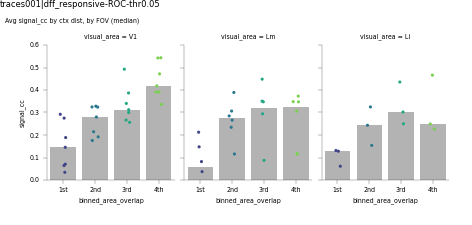

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


signal_cc_Q_area_overlap_allbins_byFOV


In [66]:
dist_cmap = 'viridis'
print(means_[['visual_area', 'datakey']].drop_duplicates()['visual_area']\
        .value_counts().to_markdown())
g = cr.plot_y_by_binned_x(means_, bin_labels, connect_fovs=False,cmap=dist_cmap,
                       metric=metric, to_quartile=to_quartile)
pl.ylim([0, .6])
g.fig.text(0.01, 0.9, 'Avg %s by ctx dist, by FOV (median)' % metric)
pplot.label_figure(g.fig, data_id)

figname = '%s_Q_%s_allbins_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

In [67]:
import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for va, df_ in means_.groupby('visual_area'):
    samples = [b_df for b, b_df in df_.groupby('binned_%s' % to_quartile)[metric]]
    f_val, p_val = ss.f_oneway(*samples)
    print('Name: {}, F value: {:.3f}, p value: {:.3f}'.format(va, f_val, p_val))

for va, df_ in means_.groupby('visual_area'):
    print('Name {}'.format(va), 
          pairwise_tukeyhsd(df_[metric], df_['binned_%s' % to_quartile]))

Name: Li, F value: 3.489, p value: 0.070
Name: Lm, F value: 1.931, p value: 0.157
Name: V1, F value: 14.668, p value: 0.000
Name Li Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1st    2nd   0.1339 0.3655 -0.1124 0.3802  False
   1st    3rd   0.2224 0.0775 -0.0238 0.4687  False
   1st    4th   0.2072 0.1025 -0.0391 0.4535  False
   2nd    3rd   0.0886 0.6586 -0.1577 0.3348  False
   2nd    4th   0.0733   0.76  -0.173 0.3196  False
   3rd    4th  -0.0152    0.9 -0.2615  0.231  False
---------------------------------------------------
Name Lm Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1st    2nd   0.2071 0.1953 -0.0723 0.4866  False
   1st    3rd   0.1389 0.5172 -0.1405 0.4184  False
   1st    4th    0.209 0.1892 -0.0704 0.4884  False
   2nd    3rd  -0.0682    0.

# RF position

In [298]:
%matplotlib notebook

In [68]:
metric = 'signal_cc'
to_quartile='rf_distance'
custom_bins=False
n_bins=4
# Bin data
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(CCRF, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
print(bcorrs.groupby(['visual_area', 'binned_%s' \
                      % to_quartile])[[to_quartile, metric]].mean().to_markdown())

|               |   rf_distance |   signal_cc |
|:--------------|--------------:|------------:|
| ('Li', '1st') |       3.11009 |   0.303364  |
| ('Li', '2nd') |       6.69285 |   0.283532  |
| ('Li', '3rd') |      10.7243  |   0.325998  |
| ('Li', '4th') |      26.1999  |   0.160143  |
| ('Lm', '1st') |       3.26503 |   0.3128    |
| ('Lm', '2nd') |       6.5479  |   0.329417  |
| ('Lm', '3rd') |      10.4104  |   0.247344  |
| ('Lm', '4th') |      25.3829  |   0.0844143 |
| ('V1', '1st') |       3.03645 |   0.400288  |
| ('V1', '2nd') |       6.54005 |   0.316285  |
| ('V1', '3rd') |      10.2302  |   0.229446  |
| ('V1', '4th') |      16.3594  |   0.138824  |


<IPython.core.display.Javascript object>


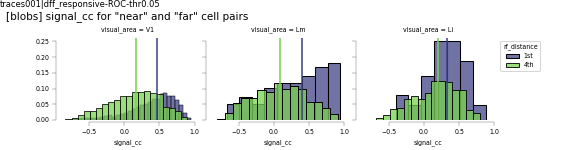

signal_cc_Q_rf_distance_aggr


In [69]:
g = cr.plot_quartile_dists_by_area(bcorrs, bin_labels, bin_colors,
                        metric=metric, to_quartile=to_quartile, extrema_only=True)

g.fig.text(0.01, 0.87, '[%s] %s for "near" and "far" cell pairs' \
           % (experiment, metric), fontsize=10)
pplot.label_figure(g.fig, data_id)
# Save
figname = '%s_Q_%s_aggr' % (metric, to_quartile)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


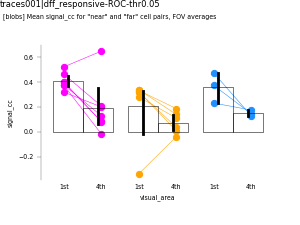

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


|    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |        2 |   0.047 | V1            |
|  1 |        5 |   0.312 | Lm            |
|  2 |        0 |   0.25  | Li            |
signal_cc_Q_rf_distance_byFOV /n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC


In [70]:
fovmeans = bcorrs\
                .groupby(['binned_%s' % to_quartile, 'visual_area', 'datakey'])\
                .mean().reset_index().dropna()
means_ = pd.concat([fc for (va, dk), fc in fovmeans\
            .groupby(['visual_area', 'datakey'])if len(fc)==len(bin_labels)])

currd = means_[means_['binned_%s' % to_quartile].isin(plot_bins)].copy()
fig, ax = pl.subplots(figsize=(4,3))
ax, pstats = pplot.pairwise_compare_single_metric(currd, 
                  curr_metric=metric, ax=ax,
                  c1=plot_bins[0], c2=plot_bins[-1], 
                  compare_var='binned_%s' % to_quartile,
                  return_stats=True, ttest=False)
#ax.set_ylim([0, 1])
print(pstats.to_markdown())
fig.text(0.01, 0.92, \
        '[%s] Mean %s for "near" and "far" cell pairs, FOV averages' \
        % (experiment, metric))
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(fig, data_id)
figname = '%s_Q_%s_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname, dst_dir)

|    |   visual_area |
|:---|--------------:|
| V1 |             7 |
| Lm |             6 |
| Li |             3 |


<IPython.core.display.Javascript object>


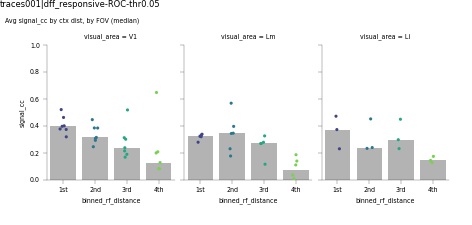

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


signal_cc_Q_rf_distance_allbins_byFOV


In [71]:
dist_cmap = 'viridis'
print(means_[['visual_area', 'datakey']].drop_duplicates()['visual_area']\
        .value_counts().to_markdown())
g = cr.plot_y_by_binned_x(means_, bin_labels, connect_fovs=False,cmap=dist_cmap,
                       metric=metric, to_quartile=to_quartile)
pl.ylim([0, 1.])
g.fig.text(0.01, 0.9, 'Avg %s by ctx dist, by FOV (median)' % metric)
pplot.label_figure(g.fig, data_id)

figname = '%s_Q_%s_allbins_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

In [72]:
import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for va, df_ in means_.groupby('visual_area'):
    samples = [b_df for b, b_df in df_.groupby('binned_%s' % to_quartile)[metric]]
    f_val, p_val = ss.f_oneway(*samples)
    print('Name: {}, F value: {:.3f}, p value: {:.3f}'.format(va, f_val, p_val))

for va, df_ in means_.groupby('visual_area'):
    print('Name {}'.format(va), 
          pairwise_tukeyhsd(df_[metric], df_['binned_%s' % to_quartile]))

Name: Li, F value: 2.425, p value: 0.141
Name: Lm, F value: 1.915, p value: 0.160
Name: V1, F value: 3.418, p value: 0.033
Name Li Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1st    2nd  -0.0501    0.9 -0.3218 0.2216  False
   1st    3rd  -0.0321    0.9 -0.3038 0.2396  False
   1st    4th  -0.2096 0.1401 -0.4813 0.0621  False
   2nd    3rd    0.018    0.9 -0.2537 0.2897  False
   2nd    4th  -0.1595 0.3079 -0.4312 0.1122  False
   3rd    4th  -0.1774 0.2345 -0.4491 0.0943  False
---------------------------------------------------
Name Lm Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1st    2nd   0.1346 0.6448 -0.1907 0.4599  False
   1st    3rd   -0.056    0.9 -0.3813 0.2693  False
   1st    4th  -0.1355 0.6406 -0.4608 0.1898  False
   2nd    3rd  -0.1906 0.3811

## RF orientation 

In [73]:
metric = 'signal_cc'
to_quartile='rf_orientation'
custom_bins=False
n_bins=4
# Bin data
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(CCRF, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
print(bcorrs.groupby(['visual_area', 'binned_%s' \
                      % to_quartile])[[to_quartile, metric]].mean().to_markdown())

|               |   rf_orientation |   signal_cc |
|:--------------|-----------------:|------------:|
| ('Li', '1st') |          8.72014 |    0.232885 |
| ('Li', '2nd') |         30.0815  |    0.201986 |
| ('Li', '3rd') |         59.6496  |    0.209326 |
| ('Li', '4th') |         81.0518  |    0.183899 |
| ('Lm', '1st') |          8.37887 |    0.203124 |
| ('Lm', '2nd') |         30.9717  |    0.162925 |
| ('Lm', '3rd') |         59.4875  |    0.128658 |
| ('Lm', '4th') |         81.4661  |    0.187737 |
| ('V1', '1st') |          8.43304 |    0.297836 |
| ('V1', '2nd') |         30.2503  |    0.286674 |
| ('V1', '3rd') |         59.8325  |    0.274667 |
| ('V1', '4th') |         81.1984  |    0.298698 |


<IPython.core.display.Javascript object>


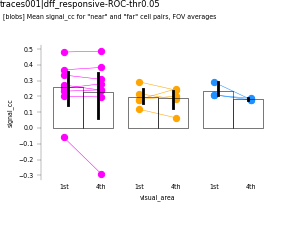

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


|    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |       15 |   0.742 | V1            |
|  1 |        6 |   0.812 | Lm            |
|  2 |        0 |   0.25  | Li            |
signal_cc_Q_rf_orientation_byFOV /n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC


In [74]:
fovmeans = bcorrs\
                .groupby(['binned_%s' % to_quartile, 'visual_area', 'datakey'])\
                .mean().reset_index().dropna()
means_ = pd.concat([fc for (va, dk), fc in fovmeans\
            .groupby(['visual_area', 'datakey'])if len(fc)==len(bin_labels)])

currd = means_[means_['binned_%s' % to_quartile].isin(plot_bins)].copy()
fig, ax = pl.subplots(figsize=(4,3))
ax, pstats = pplot.pairwise_compare_single_metric(currd, 
                  curr_metric=metric, ax=ax,
                  c1=plot_bins[0], c2=plot_bins[-1], 
                  compare_var='binned_%s' % to_quartile,
                  return_stats=True, ttest=False)
#ax.set_ylim([0, 1])
print(pstats.to_markdown())
fig.text(0.01, 0.92, \
        '[%s] Mean %s for "near" and "far" cell pairs, FOV averages' \
        % (experiment, metric))
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(fig, data_id)
figname = '%s_Q_%s_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname, dst_dir)

|    |   visual_area |
|:---|--------------:|
| V1 |             8 |
| Lm |             5 |
| Li |             3 |


<IPython.core.display.Javascript object>


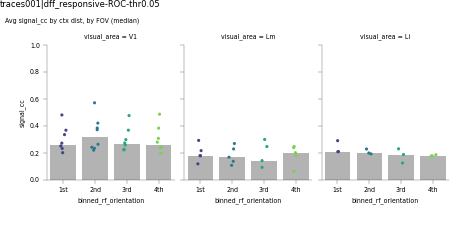

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [75]:
dist_cmap = 'viridis'
print(means_[['visual_area', 'datakey']].drop_duplicates()['visual_area']\
        .value_counts().to_markdown())
g = cr.plot_y_by_binned_x(means_, bin_labels, connect_fovs=False,cmap=dist_cmap,
                       metric=metric, to_quartile=to_quartile)
pl.ylim([0, 1.])
g.fig.text(0.01, 0.9, 'Avg %s by ctx dist, by FOV (median)' % metric)
pplot.label_figure(g.fig, data_id)


# RF-RF metrics

In [ ]:
f

In [239]:
# selective_only=False
# stimulus_type='allstim'

# assert stimulus_type in ['fullscreen', 'apertured', 'allstim']

# if stimulus_type=='fullscreen':
#     SD = fullSDF.copy()
# elif stimulus_type=='apertured':
#     SD = apSDF.copy()
# else:
#     SD = SDF.copy()
    
# roi_filter='gof%.2f' % gof_thr if selective_only else 'allcells'
# print(roi_filter)

In [471]:
min_ncells=5
selective_only=False
c_=[]
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    # ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
    # Select cells
    if selective_only:
        curr_cells = passg[(passg.visual_area==va) 
                        & (passg.datakey==dk)]['cell'].unique()
    else:
        curr_cells = ndf['cell'].unique()
    if len(curr_cells)<min_ncells:
        continue
    # Select stimuli and trials
    sdf = aggr.get_stimuli(dk, experiment='gratings')
    curr_cfgs = sdf.index.tolist()
    cc_ = calculate_corrs(ndf, curr_cells=curr_cells, curr_cfgs=curr_cfgs)
    cc_['visual_area']=va
    cc_['datakey']=dk
    c_.append(cc_)
CC = pd.concat(c_, axis=0)


In [278]:
SDF={}
for (va, dk), g in NDATA.groupby(['visual_area', 'datakey']):
    sdf = p3.get_stimuli(dk, 'gratings')
    SDF[dk] = sdf

In [279]:
fullSDF = {}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']>50][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    fullSDF[dk] = subset #.append(subset)

In [280]:
apSDF={}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']<100][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    apSDF[dk] = subset #.append(subset)

20190522_JC089_fov1
20190527_JC092_fov3


In [472]:
c_ = []
for (va, dk), cc_ in CC.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    r1 = cc_['cell_1'].unique()
    r2 = cc_['cell_2'].unique()
    rois_ = np.union1d(r1, r2)
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    pos_.index = pos_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(pos_.loc[cc_['cell_1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(pos_.loc[cc_['cell_2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    cc_['cortical_distance'] = dists
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    c_.append(cc_)
corrdist = pd.concat(c_, axis=0).reset_index(drop=True)


In [854]:
# Bin cortical distances for plotting
autosplit=False
if autosplit:
    n_bins_dist = 6
    use_quartile=False
    bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
    print("binning: %s" % bin_type)
    if use_quartile:
        corrdist['binned_dist'], bin_edges = pd.qcut(corrdist['cortical_distance'], \
                                        n_bins_dist, labels=False, retbins=True)
    else:
        corrdist['binned_dist'], bin_edges = pd.cut(corrdist['cortical_distance'], \
                                         n_bins_dist,labels=False, retbins=True)
else:
    bin_type='custombins'
    corrdist['binned_dist'] = pd.cut(x=corrdist['cortical_distance'], 
                                bins=[0, 100, 300, 500, np.inf], 
                                labels=['<100', '100-300', '300-500', '>500'])

mean_ccs = corrdist.groupby(['visual_area', 'datakey', 'binned_dist'])\
                        .mean().reset_index()

<IPython.core.display.Javascript object>


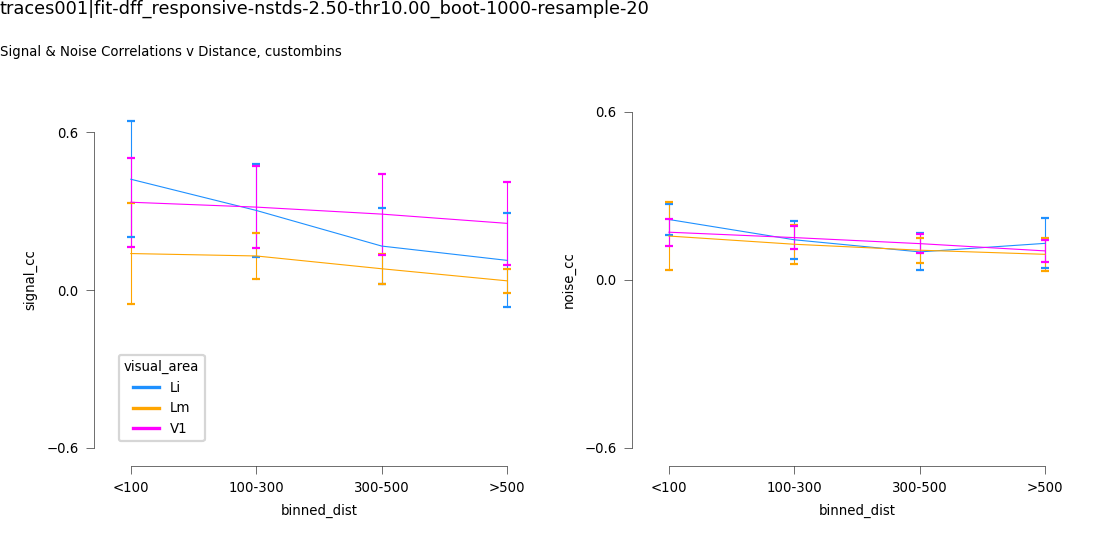

Text(0, 0.9, 'Signal & Noise Correlations v Distance, custombins')

In [855]:
lw=0.5

fig, axn = pl.subplots( 1, 2, figsize=(7,3.5)) #, sharex=True, sharey=False)
for ax, metric in zip(axn.flat, ['signal_cc', 'noise_cc']):
    sns.lineplot(x='binned_dist', y=metric, data=mean_ccs, ax=ax,
             hue='visual_area', palette=area_colors, ci='sd', err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)
    #ax.set_xticks(list(range(len(bin_edges))))
    #ax.set_xticklabels([round(i) for i in bin_edges])
    #ax.set_ylim([-0.7, 0.7])
    ax.set_yticks(np.linspace(-0.6, 0.6, 3)) #([-0.6, 0.6])
    sns.despine(offset=8, trim=True, ax=ax)
    
ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.3, hspace=0.5)

pplot.label_figure(fig, data_id)
fig.text(0, 0.9, 'Signal & Noise Correlations v Distance, %s' % bin_type)
# figname = 'sigcorrs_by_dist__%s_%s' % (stimulus_type, roi_filter)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

# Compare difference in preferred dirs

In [1420]:
c_ = []
for (va, dk), cc_ in corrdist.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    gfit_ =  passg[(passg.visual_area==va) & (passg.datakey==dk)
                  & (passg['asi']>=0.2)].copy()
    gfit_.index = gfit_['cell'].values
    rois_ =  gfit_['cell'].unique()
    if len(rois_)==0:
        continue
    tmpc = cc_[cc_['cell_1'].isin(rois_) & cc_['cell_2'].isin(rois_)].copy()
    diff_theta = gfit_.loc[tmpc['cell_1']]['theta_pref'].values \
                    - gfit_.loc[tmpc['cell_2']]['theta_pref'].values
    v = diff_theta % 360.
    thetas_range = ((v - 180) % 360) - 180 # -180, 180
    #to_deg = np.array([np.rad2deg(i) for i in thetas_range])
    #print(min(to_deg), max(to_deg))
#     thetas_range = [ (theta + 90) % 360 if (90 <= theta < 360) \
#         else (((theta) % 90) + 90) % 360 for theta in v]
#     thetas_range = np.array([(t % 180.) - 180. if ((90<t<180) or (270<t<360)) \
#                      else (t % 180.) for t in v ])
    #thetas_range2 = (v + 180) % 180. # (0, 180)
    tmpc['pref_theta_diff'] = thetas_range #% 360. #% 180.
    c_.append(tmpc)
fitdist = pd.concat(c_, axis=0).reset_index(drop=True)

fitdist['pref_theta_diff'].min(), fitdist['pref_theta_diff'].max() # Range from -180 to 180

(-176.32653061224494, 176.32653061224494)

In [1421]:
fitdist

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,visual_area,datakey,cortical_distance,binned_dist,pref_theta_diff
0,172,187,-0.478374,172_187,0.044495,Li,20190314_JC070_fov1,217.661674,100-300,95.510204
1,172,216,0.727695,172_216,0.246881,Li,20190314_JC070_fov1,451.735098,300-500,-7.346939
2,172,220,0.783481,172_220,-0.004236,Li,20190314_JC070_fov1,456.918526,300-500,-7.346939
3,172,235,0.099065,172_235,-0.005421,Li,20190314_JC070_fov1,662.784857,>500,124.897959
4,172,253,0.135893,172_253,0.067974,Li,20190314_JC070_fov1,468.471708,300-500,-58.775510
...,...,...,...,...,...,...,...,...,...,...
18042,237,266,0.460840,237_266,0.240423,V1,20191006_JC110_fov1,172.559270,100-300,-161.632653
18043,237,313,0.504684,237_313,0.081655,V1,20191006_JC110_fov1,359.807776,300-500,51.428571
18044,245,266,0.708482,245_266,0.408278,V1,20191006_JC110_fov1,96.025434,<100,-168.979592
18045,245,313,0.457018,245_313,0.116141,V1,20191006_JC110_fov1,443.795066,300-500,44.081633


In [1422]:
# # Bin cortical distances for plotting
# -----------------------------------------------
# n_bins_dist = 5
# use_quartile=False
# bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
# print("binning: %s" % bin_type)
# if use_quartile:
#     fitdist['binned_dist'], bin_edges = pd.qcut(fitdist['cortical_distance'], \
#                                     n_bins_dist, labels=False, retbins=True)
# else:
#     fitdist['binned_dist'], bin_edges = pd.cut(fitdist['cortical_distance'], \
#                                      n_bins_dist,labels=False, retbins=True)

#fitdist['binned_dist'] = None
# bins_ = [0, 100, 200, 300, 400, 500, np.inf]
# dist_labels = ['<100', '100-200', '200-300', '300-400', '400-500', '>500']

bins_ = [0, 150, 300, 450, np.inf]
dist_labels=[]
for i, b in enumerate(bins_[0:-1]):
    if i==0:
        dist_labels.append('<%i' % bins_[i+1])
    elif i==len(bins_)-2:
        dist_labels.append('>%i' % bins_[-2])
    else:
        dist_labels.append('%i-%i' % (b, bins_[i+1]))
# dist_labels = ['<100', '100-300', '300-500', '>500']
print(dist_labels)
fitdist['binned_dist'] = pd.cut(x=fitdist['cortical_distance'], 
                                bins=bins_,labels=dist_labels)


['<150', '150-300', '300-450', '>450']


In [1434]:
# bin thetas
# -----------------------------------------------
#metric='abs_diff'
metric = 'pref_theta_diff'
if metric=='abs_diff':
    fitdist['abs_diff'] = np.abs(fitdist['pref_theta_diff'])
    bins_ = np.linspace(0, 180, 6)
    theta_labels = np.linspace(0, 180, 6)[0:-1]
    fitdist['binned_theta'] = pd.cut(x=fitdist['abs_diff'],
                                     bins=bins_, labels=theta_labels)
else:
    bins_ = [-np.inf]
    vmin=-180; vmax=180;
    n_steps = 10
    int_size = np.mean(np.diff(np.linspace(vmin, vmax, n_steps)))

    rg = np.linspace(vmin, vmax, n_steps) + int_size/2.
    bins_.extend(rg[0:-1])
    bins_.append(np.inf)
    theta_labels = np.linspace(vmin, vmax, n_steps)
    fitdist['binned_theta'] = pd.cut(x=fitdist['pref_theta_diff'],
                                     bins=bins_, labels=theta_labels)
print(bins_)
print(theta_labels)

[-inf, -160.0, -120.0, -80.0, -40.0, 0.0, 40.0, 80.0, 120.0, 160.0, inf]
[-180. -140. -100.  -60.  -20.   20.   60.  100.  140.  180.]


<IPython.core.display.Javascript object>


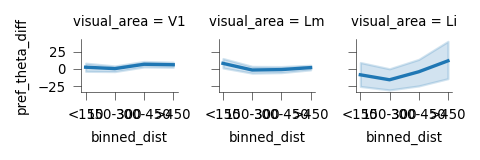

In [1435]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fitdist, height=1)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1436]:
# fitdist['abs_diff_rad'] = [np.deg2rad(i) for i in fitdist['abs_diff'].values]

# fitdist['binned_rad'] = [np.deg2rad(i) for i in fitdist['binned_theta'].values]

# print(fitdist['abs_diff_rad'].min(), fitdist['abs_diff_rad'].max())
# print(fitdist['binned_rad'].min(), fitdist['binned_rad'].max())
# fitdist.head()

In [1437]:
# Mean by FOV
mean_fitdist = fitdist.groupby(
                ['visual_area', 'datakey', 'binned_dist', 'binned_theta'])\
                .mean().reset_index().dropna()
mean_fitdist.head()
# cols = ['visual_area', 'datakey', 'binned_dist', 'binned_rad', 'abs_diff_rad']
# groups = ['visual_area', 'datakey', 'binned_dist', 'binned_rad']
# mean_fitdist = fitdist[cols].groupby(groups)\
#                         .apply(spstats.circmean, 
#                         high=np.pi, low=0, nan_policy='omit').reset_index()\
#                         .rename(columns={0: 'abs_diff_rad'})
# mean_fitdist['abs_diff'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['abs_diff_rad'].values]
# mean_fitdist['binned_theta'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['binned_rad'].values]

,visual_area,datakey,binned_dist,binned_theta,cell_1,cell_2,signal_cc,noise_cc,cortical_distance,pref_theta_diff,abs_diff
40,Li,20190314_JC070_fov1,<150,-180.0,297.0,318.0,0.050655,0.433490,107.332928,-176.326531,176.326531
41,Li,20190314_JC070_fov1,<150,-140.0,279.0,297.0,-0.149087,-0.083493,107.157176,-154.285714,154.285714
43,Li,20190314_JC070_fov1,<150,-60.0,218.0,253.0,0.293214,0.181292,101.372948,-51.428571,51.428571
44,Li,20190314_JC070_fov1,<150,-20.0,254.0,270.5,0.541135,0.144238,93.358755,-18.367347,18.367347
51,Li,20190314_JC070_fov1,150-300,-140.0,211.0,259.5,-0.128815,0.023185,271.443274,-154.285714,154.285714


In [1438]:
# d_=[]
# for (va, dk, b_dist, b_theta), g in fitdist.groupby(
#         ['visual_area', 'datakey', 'binned_dist', 'binned_theta']):
#     cells_in_bin = np.union1d(g['cell_1'].unique(), g['cell_2'].unique())
#     df_ = pd.DataFrame({'cell': cells_in_bin})
#     df_['visual_area'] = va
#     df_['datakey'] = dk
#     df_['binned_dist'] = b_dist
#     df_['binned_theta'] = b_theta
#     d_.append(df_)
# cells_in_bin = pd.concat(d_)

In [1439]:
# meanfit = fitdist.groupby(
#             ['visual_area', 'datakey', 'binned_dist'])['abs_diff']\
#             .mean().dropna().reset_index()
# meanfit.groupby(['visual_area', 'binned_dist']).mean()

<IPython.core.display.Javascript object>


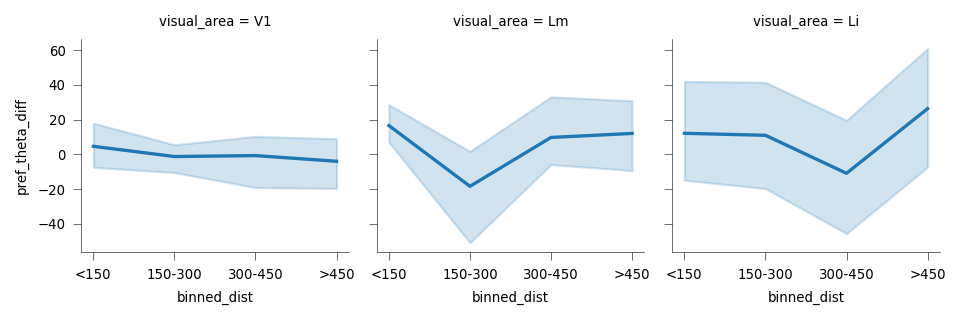

In [1440]:
meanfit = fitdist.groupby(
            ['visual_area', 'datakey', 'binned_dist'])[metric]\
            .mean().dropna().reset_index()
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=meanfit, height=2)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1441]:
counts = fitdist.groupby(['visual_area', 'binned_dist', 'binned_theta'])\
            ['neuron_pair'].count().reset_index()\
        .rename(columns={'neuron_pair': 'n_theta_bin'})
counts
counts['n_dist_bin'] = None
for (va, bd), g in counts.groupby(['visual_area', 'binned_dist']):
    counts.loc[g.index, 'n_dist_bin'] = g['n_theta_bin'].sum()
counts['fraction'] = counts['n_theta_bin'] / counts['n_dist_bin'].astype(float)

<IPython.core.display.Javascript object>


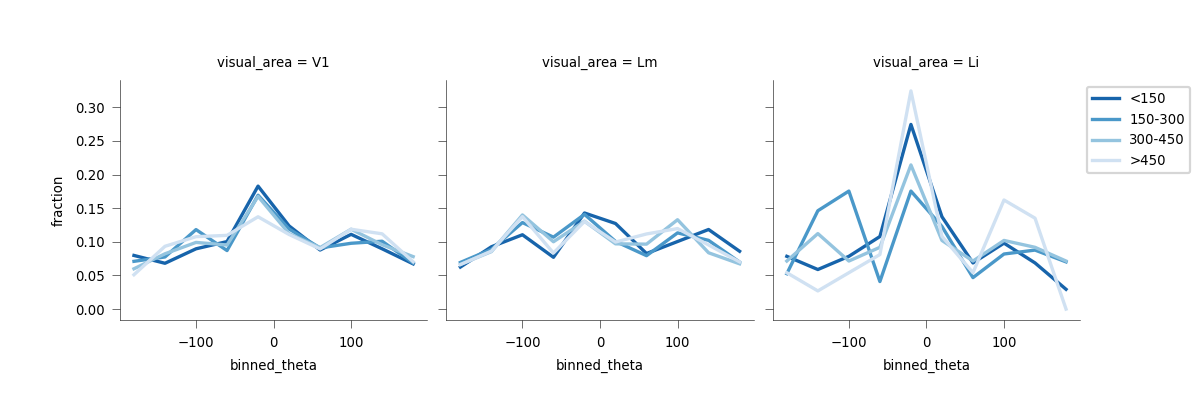

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [1442]:
dist_c = sns.color_palette('Blues_r', n_colors=len(dist_labels))
dist_colors = dict((k, v) for k, v in zip(dist_labels, dist_c))

#{'<150': 'b', '150-300': 'g', '300-450': 'r', '>450': 'k'}
plotd = counts.copy() #[counts['binned_dist']!='>450']
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=plotd,
                  height=2.5)
fg.map(sns.lineplot, 'binned_theta', 'fraction', 'binned_dist',
      palette=dist_colors)

pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

<IPython.core.display.Javascript object>


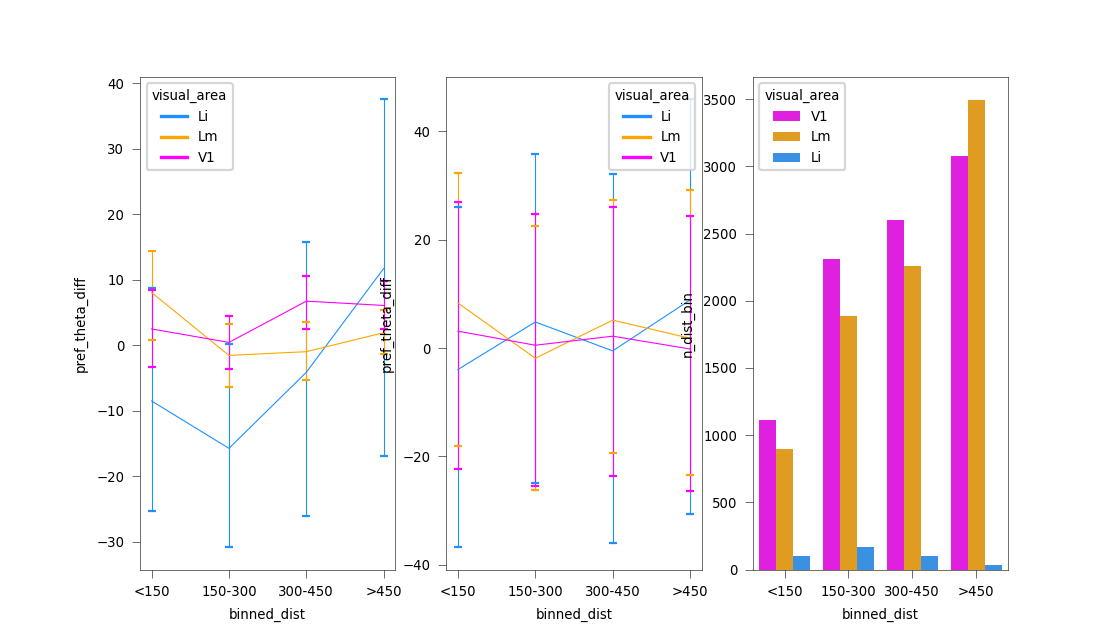

<AxesSubplot:xlabel='binned_dist', ylabel='n_dist_bin'>

In [1443]:
lw=0.5

fig, axn = pl.subplots(1,3,figsize=(7,4)) #, sharex=True, sharey=False)
# metric='abs_diff'
# metric = 'pref_deg_diff'
ax=axn[0]
sns.lineplot(x='binned_dist', y=metric, data=fitdist, ax=ax,
             hue='visual_area', palette=area_colors, ci=95,
             err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)

ax=axn[1]
sns.lineplot(x='binned_dist', y=metric, data=mean_fitdist, ax=ax,
             hue='visual_area', palette=area_colors, ci=95,
             err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)

ax=axn[2]
plotd = counts[['visual_area', 'binned_dist', 'n_dist_bin']].drop_duplicates()
sns.barplot(x='binned_dist', y='n_dist_bin', data=plotd, ax=ax,
           hue='visual_area', palette=area_colors, hue_order=visual_areas)